# 解压缩数据集

In [18]:
!unzip ../data/flower_dataset.zip -d ./data>> /dev/null

## 查看文件结构

In [169]:
!sudo snap install tree

tree 1.8.0+pkg-3fd6 已从 林博仁(Buo-ren, Lin) (brlin) 安装      |0m 910ms


In [6]:
!tree ../data -L 2

locales-launch: Data of zh_CN locale not found, generating, please wait...
../data
├── flower_dataset
│   ├── daisy
│   ├── dandelion
│   ├── rose
│   ├── sunflower
│   └── tulip
└── flower_dataset.zip

6 directories, 1 file


# 导入工具包

In [1]:
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import pandas as pd

import shutil
import os

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 随机数和python函数库
import random
import math

# 进度条
from tqdm import tqdm

# cv库
import cv2 as cv

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda', index=0)

## 删除多余文件

In [107]:
!for i in `find . -iname '__MACOSX'`; do rm -rf $i;done

In [108]:
!for i in `find . -iname '.DS_Store'`; do rm -rf $i;done

In [114]:
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

# 划分训练集和测试集

## 统计类别数

In [147]:
# 指定原始数据集路径
dataset_path = './data/flower_dataset/'

In [148]:
dataset_name = dataset_path
print('数据集', dataset_name)
classes = os.listdir(dataset_path)

数据集 ./data/flower_dataset/


In [149]:
!find . -iname '.ipynb_checkpoints'

In [139]:
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

In [150]:
!find . -iname '.ipynb_checkpoints'

In [151]:
classes

['sunflower', 'tulip', 'rose', 'dandelion', 'daisy']

In [152]:
len(classes)

5

## 划分、移动文件

### 获取所有类别名称

In [61]:
# 指定数据集路径
dataset_path = './data/flower_dataset/'
os.chdir(dataset_path)
print("len:", len(os.listdir()))
print(os.listdir())

len: 5
['sunflower', 'tulip', 'rose', 'dandelion', 'daisy']


In [62]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset'

In [63]:
cd ../../

/home/featurize/work/OpenMMlab_AI_2023.2/run


### 制作classes.txt

In [64]:
!touch ./data/classes.txt

In [106]:
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

In [66]:
os.listdir(os.chdir('./data/flower_dataset'))[0]

'sunflower'

In [67]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset'

In [68]:
with open('../classes.txt', 'w') as f:
    for i in os.listdir():
        f.write(i + '\n')

In [69]:
cat ../classes.txt

sunflower
tulip
rose
dandelion
daisy


In [70]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset'

In [74]:
cd ../../

/home/featurize/work/OpenMMlab_AI_2023.2/run


### 创建train.txt和val.txt

In [184]:
!touch ./data/train.txt

In [185]:
!touch ./data/val.txt

In [186]:
dataset_path

'./data/flower_dataset/'

In [78]:
test_frac = 0.2  # 测试集比例
random.seed(123) # 随机数种子，便于复现

In [94]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run'

In [81]:
train_val_path = '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/'

In [82]:
train_val_path

'/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/'

## 创建训练集，测试集文件夹

In [155]:
dataset_path

'./data/flower_dataset/'

In [156]:
# 创建 train 文件夹
os.mkdir(os.path.join(dataset_path, 'train'))

# 创建 test 文件夹
os.mkdir(os.path.join(dataset_path, 'val'))

# 在 train 和 test 文件夹中创建各类别子文件夹
for flower in classes:
    os.mkdir(os.path.join(dataset_path, 'train', flower))
    os.mkdir(os.path.join(dataset_path, 'val', flower))

In [157]:
len(os.listdir(dataset_path+'/train'))

5

In [158]:
len(os.listdir(dataset_path+'/val'))

5

In [159]:
df = pd.DataFrame()
path_train = []
path_val = []
count = 0

print('{:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数'))

for flower in classes: # 遍历每个类别

    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, flower)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_numer = int(len(images_filename) * test_frac) # 测试集图像个数
    testset_images = images_filename[:testset_numer]      # 获取拟移动至 test 目录的测试集图像文件名
    trainset_images = images_filename[testset_numer:]     # 获取拟移动至 train 目录的训练集图像文件名
    # 将训练集和测试集对应的图像[空格]类别写入列表中
    for i in trainset_images:
        path_train.append(f'{train_val_path}{flower}'+'/'+i + f' {count}')
    for i in testset_images:
        path_val.append(f'{train_val_path}{flower}'+'/'+i + f' {count}')
    
    count += 1    
    
    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, flower, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path, 'val', flower, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, flower, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path, 'train', flower, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件
    
    # 删除旧文件夹
    assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18}'.format(flower, len(trainset_images), len(testset_images)))
    
    # 保存到表格中
    df = df.append({'class':flower, 'trainset':len(trainset_images), 'testset':len(testset_images)}, ignore_index=True)


# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数      
    sunflower             429                107        
      tulip               468                117        
       rose               467                116        
    dandelion             445                111        
      daisy               471                117        


In [160]:
len(path_train)

2280

In [161]:
len(path_val)

568

In [187]:
path_train[0:5]

['/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/14678298676_6db8831ee6_m.jpg 0',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/1715303025_e7065327e2.jpg 0',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/2307673262_e1e1aefd29.jpg 0',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/5025805406_033cb03475_n.jpg 0',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/15839183375_49bf4f75e8_m.jpg 0']

In [188]:
path_val[-10:-5]

['/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/8322526877_95d1c0f8bc_n.jpg 4',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/3415180846_d7b5cced14_m.jpg 4',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/6054952060_c88612f3c5_n.jpg 4',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/34554334542_7d8f68a75c_n.jpg 4',
 '/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/9161647994_e39b65cb9c_n.jpg 4']

### 写入train.txt和val.txt

In [189]:
with open('./data/train.txt', 'w') as f:
    for i in path_train:
        f.write(i + '\n')
with open('./data/val.txt', 'w') as f:
    for i in path_val:
        f.write(i + '\n')

In [190]:
!head ../data/train.txt

/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/14678298676_6db8831ee6_m.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/1715303025_e7065327e2.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/2307673262_e1e1aefd29.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/5025805406_033cb03475_n.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/15839183375_49bf4f75e8_m.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/28661674053_44f8034570_n.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/3514340206_efb8198a80_n.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/15683877266_42e0fe3782_n.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/sunflower/857698097_8068a2c135_n.jpg 0
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower

In [191]:
!tail -n 10 ../data/train.txt

/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/9310226774_d1b8f5d9c9.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/2473825306_62fd5f8785_n.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/13953307149_f8de6a768c_m.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/3628485766_4ff937954a_n.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/3463313493_9497aa47e5_n.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/10841136265_af473efc60.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/5135131051_102d4878ca_n.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/7538403124_f2fc48750a.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/33879354664_615c72773d_n.jpg 4
/home/featurize/work/OpenMMlab_AI_2023.2/run/data/flower_dataset/daisy/3474942718_c418dae6f1.j

In [192]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run'

### 移动.txt文件位置

In [193]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run'

In [171]:
!mv ./data/classes.txt ./data/train.txt ./data/val.txt ./data/flower_dataset/

In [195]:
!tree ./data/flower_dataset/ -L 2

./data/flower_dataset/
├── classes.txt
├── train
│   ├── daisy
│   ├── dandelion
│   ├── rose
│   ├── sunflower
│   └── tulip
├── train.txt
├── val
│   ├── daisy
│   ├── dandelion
│   ├── rose
│   ├── sunflower
│   └── tulip
└── val.txt

12 directories, 3 files


# 配置环境

In [6]:
!pip install openmim mmengine

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 51 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 331 kB 61.8 MB/s eta 0:00:01
     |████████████████████████████████| 239 kB 59.0 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 47.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 60.3 MB/s eta 0:00:01
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.10.0
    Uninstalling Pygments-2.10.0:
      Successfully uninstalled Pygments-2.10.0


In [7]:
!mim install  mmcv-full mmcls

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html
     |████████████████████████████████| 58.2 MB 97 kB/s  eta 0:00:011    |█████████▌                      | 17.3 MB 1.2 MB/s eta 0:00:34     |██████████▌                     | 19.1 MB 1.2 MB/s eta 0:00:32     |██████████▊                     | 19.4 MB 1.2 MB/s eta 0:00:32     |███████████▋                    | 21.0 MB 4.9 MB/s eta 0:00:08     |████████████                    | 21.6 MB 4.9 MB/s eta 0:00:08     |████████████▎                   | 22.4 MB 4.9 MB/s eta 0:00:08     |████████████▌                   | 22.7 MB 4.9 MB/s eta 0:00:08     |██████████████▍                 | 26.2 MB 5.6 MB/s eta 0:00:06     |███████████████                 | 27.4 MB 5.6 MB/s eta 0:00:06     |███████████████▊                | 28.6 MB 5.6 MB/s eta 0:00:06
     |████████████████████████████████| 648 kB 39.0 MB/s eta 0:00:01


## 验证安装是否成功

In [8]:
import mmcv
import mmcls

## 下载一个训练好的模型

模型继承自：https://github.com/open-mmlab/mmclassification/tree/master/configs

In [10]:
!mim download mmcls --config resnet18_8xb32_in1k --dest .

processing resnet18_8xb32_in1k...
resnet18_8xb32_in1k_20210831-fbbb1da6.pth exists in /home/featurize/work/OpenMMlab_AI_2023.2/run
Successfully dumped resnet18_8xb32_in1k.py to /home/featurize/work/OpenMMlab_AI_2023.2/run


## 修改模型配置

直接在resnet18_8xb32_in1k.py上修改配置文件，并覆盖原来的resnet18_8xb32_in1k.py文件

In [196]:
model = dict(
    type='ImageClassifier',
    backbone=dict(
        type='ResNet',
        depth=18,
        num_stages=4,
        out_indices=(3, ),
        style='pytorch'),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=5,
        in_channels=512,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0),
        topk=(1, 5)))

data = dict(
    samples_per_gpu=32,
    workers_per_gpu=2,
    train=dict(
        type='CustomDataset',
        data_prefix='data/flower_dataset/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='RandomResizedCrop', size=224),
            dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='ToTensor', keys=['gt_label']),
            dict(type='Collect', keys=['img', 'gt_label'])
        ]),
    val=dict(
        type='CustomDataset',
        data_prefix='data/flower_dataset/val',
        # ann_file='data/flower_dataset/val.txt',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='Resize', size=(256, -1)),
            dict(type='CenterCrop', crop_size=224),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ]),
    test=dict(
        type='CustomDataset',
        data_prefix='data/flower_dataset/val',
        # ann_file='data/flower_dataset/val.txt',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='Resize', size=(256, -1)),
            dict(type='CenterCrop', crop_size=224),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ]))
evaluation = dict(interval=1, metric='accuracy')
optimizer = dict(type='SGD', lr=0.0125, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='step', step=[30, 60, 90])
runner = dict(type='EpochBasedRunner', max_epochs=10)
checkpoint_config = dict(interval=5)
log_config = dict(interval=20, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'resnet18_8xb32_in1k_20210831-fbbb1da6.pth'
resume_from = None
workflow = [('train', 1)]


## 执行训练在flower数据集中微调参数

In [199]:
!mim train mmcls resnet18_8xb32_in1k.py

/environment/miniconda3/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
Training command is /environment/miniconda3/bin/python /environment/miniconda3/lib/python3.7/site-packages/mmcls/.mim/tools/train.py resnet18_8xb32_in1k.py --launcher none --gpus 1. 
/environment/miniconda3/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. 

使用其他模型微调尝试。

In [200]:
pwd

'/home/featurize/work/OpenMMlab_AI_2023.2/run'

In [208]:
!mim train mmcls mobilenet-v2_flower5.py

/environment/miniconda3/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
Training command is /environment/miniconda3/bin/python /environment/miniconda3/lib/python3.7/site-packages/mmcls/.mim/tools/train.py mobilenet-v2_flower5.py --launcher none --gpus 1. 
/environment/miniconda3/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv.

## 找一张图片测试一下

In [203]:
from mmcls.apis import init_model, inference_model

model = init_model('resnet18_8xb32_in1k.py', 'work_dirs/resnet18_8xb32_in1k/latest.pth')
result = inference_model(model, 'daisy_1.png')
print(result)

load checkpoint from local path: work_dirs/resnet18_8xb32_in1k/latest.pth
{'pred_label': 0, 'pred_score': 0.8768838047981262, 'pred_class': 'daisy'}


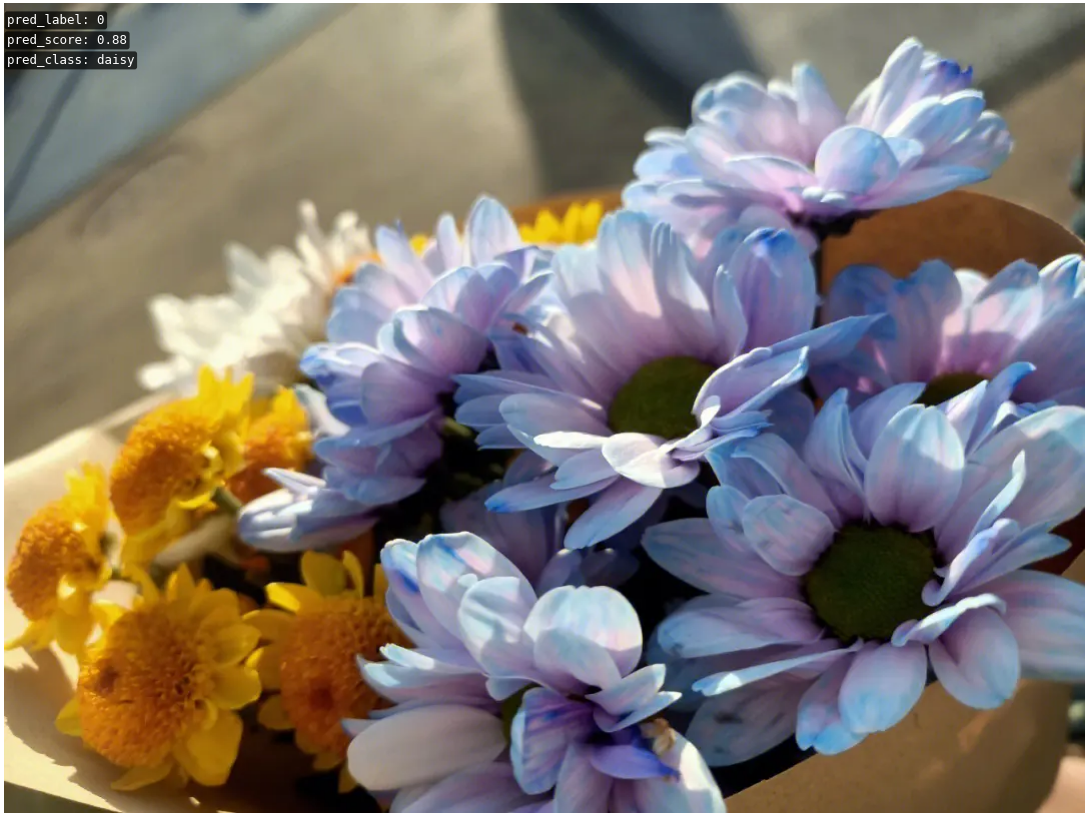

In [204]:
from mmcls.apis import show_result_pyplot

show_result_pyplot(model, 'daisy_1.png', result)

In [205]:
model = init_model('resnet18_8xb32_in1k.py', 'work_dirs/resnet18_8xb32_in1k/latest.pth')
result = inference_model(model, 'daisy_2.jpg')
print(result)

load checkpoint from local path: work_dirs/resnet18_8xb32_in1k/latest.pth
{'pred_label': 0, 'pred_score': 0.9996387958526611, 'pred_class': 'daisy'}


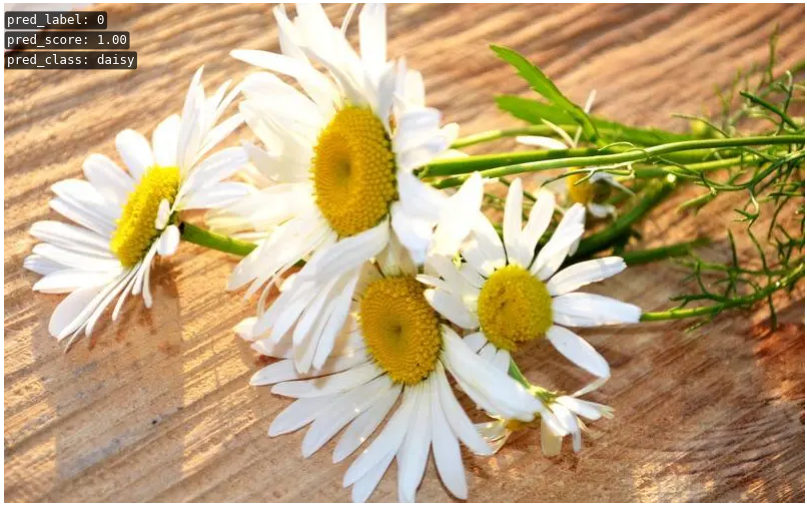

In [206]:
from mmcls.apis import show_result_pyplot

show_result_pyplot(model, 'daisy_2.jpg', result)